In [1]:

import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
from tqdm import tqdm
import copy
from IPython.display import display, Image, clear_output
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import datetime


import cv2
import os
import glob


import kornia
import tqdm

import torchvision

tt = torchvision.transforms.ToTensor()

import cv2
import cv2.aruco as aruco
import numpy as np

from classfier import *

import pickle as pkl

with open("photometric_calibration.pkl", "rb") as f:
    data = pkl.load(f)

height = data['height']
width = data['width']

resizer = torchvision.transforms.Resize((height, width))
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Define parameters for ArUco marker detection
aruco_dict_type = cv2.aruco.DICT_6X6_250 # Change dictionary type if needed
marker_length = 0.05  # Marker length in meters (adjust as needed)
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)

marker_id = 40
marker_size = 500  # Size in pixels
marker_image = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)


aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
parameters = aruco.DetectorParameters()

# Detect ArUco markers
detector = aruco.ArucoDetector(aruco_dict, parameters)


from diffusers import StableDiffusionPipeline
import torch

# Load stable diffusion model


def decode_latents_grad(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    latents = 1 / 0.18215 * latents

    imgs = vae.decode(latents).sample

    imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def decode_latents(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    with torch.no_grad():
        with torch.amp.autocast(device):
            latents = 1 / 0.18215 * latents

            with torch.no_grad():
                imgs = vae.decode(latents).sample

            imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def encode_imgs(imgs):
    # imgs: [B, 3, H, W]
    with torch.no_grad():
        with torch.amp.autocast(device):
            imgs = 2 * imgs - 1

            posterior = vae.encode(imgs).latent_dist
            latents = posterior.sample() * 0.18215

    return latents



class framesDataset(Dataset):
    def __init__(self, frames, Hs):
        self.frames = frames
        self.Hs = Hs

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        H = self.Hs[idx]

        # Convert to tensor and normalize
        frame_tensor = tt(frame)

        return frame_tensor, H.astype(np.float32)
    





def warp(decoded_latents,H_t):
    dst_img_shape = valid_frames[0].shape[:2]
    warped_imgs = []
    for decoded_latent in decoded_latents:
        img = decoded_latent.unsqueeze(0).float().repeat(H_t.shape[0], 1, 1, 1)
        w=  kornia.geometry.transform.warp_perspective(img, H_t, dst_img_shape)
        warped_imgs.append(w)
    return torch.stack(warped_imgs, dim=0)#.squeeze(1)


vae = None
valid_frames = None

os.makedirs('./results', exist_ok=True)
curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
curr_without_sec = curr_without_sec.replace(" ", "_").replace(":", "_")




pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

vae =  pipe.vae.to(device).eval()

latent = (torch.rand((5,4, 4, 4), device=device) - 0.5) * 2

# latent = torch.load(r"C:\git\PhysicalAdverserialProj\results\working_latent_multiview_2025-09-15_20").to(device)
latent = latent.clone().detach()
with torch.no_grad():
    decoded_latents = resizer(decode_latents(latent))


l_size_h = decoded_latents.shape[-2]
l_size_w = decoded_latents.shape[-1]

# Track running mean loss per latent/patch across batches
num_latents = latent.shape[0]

orig_img_corners = np.array([[0,0],[l_size_w,0],[l_size_w,l_size_h],[0,l_size_h]], dtype=np.float32)


border_size = 0

ls = os.listdir('.')
captures = [f for f in ls if f.startswith('captures_frames_multiview_') ]
cap_dir = f'captures_frames_multiview_{len(captures)-1}'
print('using capture dir', cap_dir)

valid_frame_paths = glob.glob(f'{cap_dir}/*.png')

valid_frames = []

Hs = []

for path in tqdm.tqdm_notebook(valid_frame_paths):
    img = cv2.imread(path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    corners, ids, _ = detector.detectMarkers(gray)

    with torch.no_grad():
        pr = resnet_predict_raw(tt(img).cuda().unsqueeze(0))

    if ids is not None and pr.argmax(1) in orig_clases:

        c = corners[0][0]
        unbordred_corners = np.array([[c[0][0]-border_size, c[0][1]+border_size],
                            [c[1][0]-border_size, c[1][1]-border_size],
                            [c[2][0]+border_size, c[2][1]-border_size],
                            [c[3][0]+border_size, c[3][1]+border_size]])

        dst_pts = unbordred_corners
        H, _ = cv2.findHomography(orig_img_corners, dst_pts, cv2.RANSAC)

        Hs.append(H)
        valid_frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print(f"Found {len(valid_frames)} valid frames with ArUco markers and original classes.")

# Use ALL valid frames instead of limiting to 10
print(f"Using ALL {len(valid_frames)} frames for training.")

# No need to subset - use all valid frames
# valid_frames and Hs already contain all valid frames


ds = framesDataset(valid_frames, Hs)


print('creating dataloader')
# Calculate split sizes that sum to dataset length
total_len = len(ds)
train_len = int(total_len * 0.8)
val_len = int(total_len * 0.1)
test_len = total_len - train_len - val_len  # Ensure exact sum

print(f"Dataset split: train={train_len}, val={val_len}, test={test_len}, total={total_len}")
train,val,test = torch.utils.data.random_split(ds, [train_len, val_len, test_len])
train_loader = DataLoader(train, batch_size=1, shuffle=True)#, num_workers=2, persistent_workers=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=False)#), num_workers=2, persistent_workers=True)
test_loader = DataLoader(test, batch_size=len(test), shuffle=False)#, num_workers=2, persistent_workers=True)

print('dataloader created')
    
# latent.requires_grad = True

latent_batch_size = 16


latent_batches = torch.split(latent, latent_batch_size)

for idx,latent_batch in enumerate(latent_batches):
    latent_batch.requires_grad = True

lrs = [10 * 10**(-1 * idx) for idx in range(len(latent_batches))]
latent_opts = [torch.optim.Adam([latent_batch], lr=lrs[idx]) for idx,latent_batch in enumerate(latent_batches)]





jitter = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
jitter_total_photo = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
jitter_with_hue = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)

augmentor = data['augmentor'].to(device).eval()
# mapper = lambda x: jitter(x)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

using capture dir captures_frames_multiview_25


C:\Users\danny\AppData\Local\Temp\ipykernel_11204\4060463456.py:188: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for path in tqdm.tqdm_notebook(valid_frame_paths):


  0%|          | 0/639 [00:00<?, ?it/s]

Found 370 valid frames with ArUco markers and original classes.
Using ALL 370 frames for training.
creating dataloader
Dataset split: train=296, val=37, test=37, total=370
dataloader created


In [2]:
# No need to load single frame - we'll iterate through all frames
print(f"Dataset contains {len(train_loader)} training batches")
print(f"Total training frames: {len(train_loader.dataset)}")
print(f"Validation frames: {len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0}")
print(f"Test frames: {len(test_loader.dataset) if len(test_loader.dataset) > 0 else 0}")
print("Ready to process ALL frames during training!")

Dataset contains 296 training batches
Total training frames: 296
Validation frames: 37
Test frames: 37
Ready to process ALL frames during training!


In [3]:
sample_frame, sample_H = next(iter(train_loader))


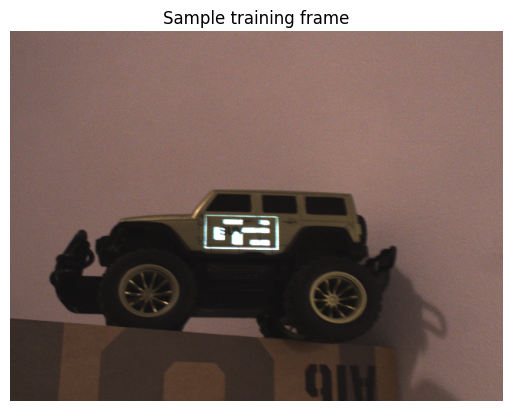

In [4]:
# Display a sample frame from the dataset
sample_frame, sample_H = next(iter(train_loader))
plt.imshow(sample_frame[0].permute(1,2,0).cpu().numpy())
plt.title("Sample training frame")
plt.axis('off')
plt.show()

In [5]:
# Load successful latent if available, otherwise reinitialize
print("Attempting to load successful latent or reinitializing...")

# Try to load a previously successful latent
# try:
#     latent_batch = torch.load('./results/successful_latent_2025-09-20_18_23.pt').to(device)
#     print("✓ Loaded successful latent from previous run!")
# except:
    # If no successful latent available, use a different initialization strategy
latent_batch = torch.randn((30, 4, 4, 4), device=device) * 0.8  # Larger initial noise
print("Using fresh random initialization with larger variance")

latent_batch.requires_grad = True

# Use a more conservative optimizer with higher learning rate
latent_opt = torch.optim.Adam([latent_batch], lr=0.1)  # Higher LR, simpler optimizer
scheduler = torch.optim.lr_scheduler.StepLR(latent_opt, step_size=50, gamma=0.9)  # More frequent decay

print(f"Latent shape: {latent_batch.shape}")
print(f"Original classes to avoid: {orig_clases.cpu().numpy()}")
print(f"Other classes available: {len(total_clases_without_orig)}")

# Test initial prediction
with torch.no_grad():
    test_patch = resizer(decode_latents(latent_batch).float())
    print(f"Generated patch shape: {test_patch.shape}")
    print("Initialization complete!")

Attempting to load successful latent or reinitializing...
Using fresh random initialization with larger variance
Latent shape: torch.Size([30, 4, 4, 4])
Original classes to avoid: [817 705 609 586 436 627 468 621 803 407 408 751 717 866 661]
Other classes available: 985
Generated patch shape: torch.Size([30, 3, 100, 214])
Initialization complete!


In [ ]:
# Robust adversarial attack working on ALL frames with augmentation training
print("Starting ROBUST adversarial attack on ALL frames in dataset...")
print("🔧 Augmentations enabled: jitter on patch, augmentor on patch, jitter_total_photo on final image")
print("This will make the patch robust against real-world variations!")

# Training parameters
num_epochs = 250  # Increased since augmentation training is more challenging
blend_ratio = 1.0  # Full replacement
best_loss = float('inf')
best_latent = None
best_success_rate = 0
success_count = 0
training_stopped = False  # Flag for early stopping when patch > 50%

# Loss tracking
losses = []
success_rates = []

# Per-patch performance tracking
num_patches = latent_batch.shape[0]
patch_success_history = {i: [] for i in range(num_patches)}  # Track each patch over time
patch_augmented_success_history = {i: [] for i in range(num_patches)}  # Track augmented performance

# Better target class selection - classes that are visually very different from vehicles
target_classes = torch.tensor([
    1,    # tench (fish)
    2,    # goldfish  
    3,    # great white shark
    4,    # tiger shark
    50,   # American robin (bird)
    285,  # Egyptian cat
    281,  # tabby cat
    805,  # soccer ball
    999,  # toilet tissue
    732,  # Polaroid camera (this worked before!)
    530,  # digital clock
], device=device)
# target_classes = torch.tensor([x for x in range(1000) if x not in orig_clases.cpu().numpy()], device=device)

print(f"Target classes: {[weights.meta['categories'][i] for i in target_classes.cpu().numpy()]}")
print(f"Training on {len(train_loader)} batches per epoch (ALL frames)")

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_success_rates = []
    
    # Process ALL frames in the training set
    for batch_idx, (frames_batch, H_t_batch) in tqdm.tqdm(enumerate(train_loader)):
        latent_opt.zero_grad()
        
        frames_batch = frames_batch.to(device)
        H_t_batch = H_t_batch.to(device)
        
        # Generate adversarial patch from latent
        adv_patch = resizer(decode_latents_grad(latent_batch).float())
        
        # Apply jitter augmentation to the patch for robustness
        if torch.rand(1).item() > 0.3:  # 70% chance to apply patch augmentation
            adv_patch_aug = jitter(adv_patch)
        else:
            adv_patch_aug = adv_patch
            
        # Apply augmentor transformation to patch for additional robustness
        # Skip augmentor for now due to size constraints - use only jitter augmentations
        if torch.rand(1).item() > 0.3:  # 70% chance to apply augmentor
            adv_patch_aug = torch.stack([augmentor(x).to(device) for x in adv_patch_aug])
        
        # Apply warping to current batch of frames
        w_mask = warp(adv_patch_aug * 0 + 1, H_t_batch)
        w_patch = warp(adv_patch_aug, H_t_batch)
        
        # Full replacement for maximum effect
        blended_frames = ((w_mask != 0) * -blend_ratio + 1) * frames_batch + w_patch * blend_ratio
        
        # Apply jitter_total_photo to the entire blended result for robustness
        if torch.rand(1).item() > 0.3:  # 70% chance to apply total photo jitter
            blended_frames = jitter_total_photo(blended_frames)
        
        # Reshape for batch processing
        batch_frames = blended_frames.view(-1, *blended_frames.shape[2:])
        
        # Preprocess for model
        processed_batch = preprocess(batch_frames)
        
        # Get model predictions
        logits = model(processed_batch)
        probs = torch.softmax(logits, dim=1)
        
        # Improved loss calculation
        # 1. Strong penalty for original classes
        orig_class_probs = probs[:, orig_clases]
        orig_loss = 5.0 * torch.log(orig_class_probs.sum(dim=1) + 1e-10).mean()
        
        # 2. Strong reward for our specific target classes
        target_probs = probs[:, target_classes]
        target_loss = -3.0 * torch.log(target_probs.max(dim=1)[0] + 1e-10).mean()
        
        # 3. Minimal regularization
        # patch_reg = 0.0001 * (adv_patch - 0.5).pow(2).mean()
        
        # Combined loss
        total_loss = orig_loss + target_loss #+ patch_reg
        
        # Backward pass
        total_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_([latent_batch], max_norm=3.0)
        
        latent_opt.step()
        
        # Track metrics for this batch
        epoch_losses.append(total_loss.item())
        
        # Evaluation for this batch
        with torch.no_grad():
            predictions = logits.argmax(dim=1)
            successful_attacks = sum(pred.item() not in orig_clases.cpu().numpy() for pred in predictions)
            success_rate = successful_attacks / len(predictions)
            epoch_success_rates.append(success_rate)
    
    # Update scheduler once per epoch
    scheduler.step()
    
    # Calculate epoch averages
    avg_epoch_loss = np.mean(epoch_losses)
    avg_epoch_success = np.mean(epoch_success_rates)
    
    losses.append(avg_epoch_loss)
    success_rates.append(avg_epoch_success)
    
    # Per-patch performance evaluation on augmented data (every 5 epochs or when successful)
    if epoch % 5 == 0 or avg_epoch_success > 0.3:
        print(f"\n📊 Evaluating individual patch performance on augmented data...")
        
        with torch.no_grad():
            # Generate all patches
            all_patches = resizer(decode_latents(latent_batch).float())
            
            # Test each patch individually on a small subset of validation data
            val_batch_limit = min(3, len(val_loader))  # Use first 3 validation batches
            
            for patch_idx in range(num_patches):
                patch_clean_successes = 0
                patch_aug_successes = 0
                total_tests = 0
                
                single_patch = all_patches[patch_idx:patch_idx+1]  # Keep batch dimension
                
                for val_batch_idx, (val_frames, val_H_t) in enumerate(val_loader):
                    if val_batch_idx >= val_batch_limit:
                        break
                        
                    val_frames = val_frames.to(device)
                    val_H_t = val_H_t.to(device)
                    
                    # === CLEAN PATCH TEST ===
                    w_mask = warp(single_patch * 0 + 1, val_H_t)
                    w_patch = warp(single_patch, val_H_t)
                    clean_blended = ((w_mask != 0) * -blend_ratio + 1) * val_frames + w_patch * blend_ratio
                    clean_batch = clean_blended.view(-1, *clean_blended.shape[2:])
                    
                    clean_processed = preprocess(clean_batch)
                    clean_logits = model(clean_processed)
                    clean_predictions = clean_logits.argmax(dim=1)
                    
                    # === AUGMENTED PATCH TEST ===
                    aug_patch = jitter(single_patch)
                    try:
                        aug_patch = torch.stack([augmentor(x).to(device) for x in aug_patch])
                    except:
                        pass  # Use only jitter if augmentor fails
                    
                    w_mask_aug = warp(aug_patch * 0 + 1, val_H_t)
                    w_patch_aug = warp(aug_patch, val_H_t)
                    aug_blended = ((w_mask_aug != 0) * -blend_ratio + 1) * val_frames + w_patch_aug * blend_ratio
                    aug_blended = jitter_total_photo(aug_blended)
                    aug_batch = aug_blended.view(-1, *aug_blended.shape[2:])
                    
                    aug_processed = preprocess(aug_batch)
                    aug_logits = model(aug_processed)
                    aug_predictions = aug_logits.argmax(dim=1)
                    
                    # Count successes
                    for pred in clean_predictions:
                        if pred.item() not in orig_clases.cpu().numpy():
                            patch_clean_successes += 1
                        total_tests += 1
                    
                    for pred in aug_predictions:
                        if pred.item() not in orig_clases.cpu().numpy():
                            patch_aug_successes += 1
                
                # Calculate success rates for this patch
                clean_rate = patch_clean_successes / total_tests if total_tests > 0 else 0
                aug_rate = patch_aug_successes / total_tests if total_tests > 0 else 0
                
                # Store in history
                patch_success_history[patch_idx].append(clean_rate)
                patch_augmented_success_history[patch_idx].append(aug_rate)
        
        # Report top performing patches
        if len(patch_success_history[0]) > 0:  # If we have data
            print(f"🏆 TOP 5 PATCHES (Augmented Performance):")
            
            # Get latest augmented performance for each patch
            latest_aug_performance = [(i, patch_augmented_success_history[i][-1]) for i in range(num_patches)]
            latest_aug_performance.sort(key=lambda x: x[1], reverse=True)
            
            # Check if any patch achieved > 50% success rate
            best_patch_idx, best_patch_rate = latest_aug_performance[0]
            
            for rank, (patch_idx, aug_rate) in enumerate(latest_aug_performance[:5], 1):
                clean_rate = patch_success_history[patch_idx][-1]
                robustness = (aug_rate / clean_rate) if clean_rate > 0 else 0
                print(f"  {rank}. Patch #{patch_idx+1:2d}: Clean {clean_rate:.1%} | Aug {aug_rate:.1%} | Robust {robustness:.1%}")
            
            # Show worst performers too
            print(f"📉 BOTTOM 3 PATCHES (Augmented Performance):")
            for rank, (patch_idx, aug_rate) in enumerate(latest_aug_performance[-3:], 1):
                clean_rate = patch_success_history[patch_idx][-1]
                print(f"  {rank}. Patch #{patch_idx+1:2d}: Clean {clean_rate:.1%} | Aug {aug_rate:.1%}")
            # Check for 90% threshold on individual patches
            if best_patch_rate > 0.9:
                print(f"\n🎉 BREAKTHROUGH! Patch #{best_patch_idx+1} achieved {best_patch_rate:.1%} success rate!")
                print(f"🛑 STOPPING TRAINING - 90% threshold exceeded!")

                # Save the successful patch immediately
                current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")
                
                # Save the best latent
                best_patch_latent = latent_batch[best_patch_idx:best_patch_idx+1].clone().detach()
                torch.save(best_patch_latent, f'./results/successful_patch_{best_patch_idx+1}_epoch_{epoch}_{current_time}.pt')
                
                # Save the full latent batch for completeness
                torch.save(latent_batch.clone().detach(), f'./results/full_latent_batch_epoch_{epoch}_{current_time}.pt')
                
                print(f"💾 Saved successful patch to: ./results/successful_patch_{best_patch_idx+1}_epoch_{epoch}_{current_time}.pt")
                print(f"💾 Saved full batch to: ./results/full_latent_batch_epoch_{epoch}_{current_time}.pt")
                
                # Set flags to break out of training
                training_stopped = True
                break
        
        print()  # Add spacing
    
    # Check if training was stopped due to high-performing patch
    if training_stopped:
        print(f"Training stopped early due to patch achieving >50% success rate")
        break
    
    if avg_epoch_success > 0:
        success_count += 1
        
    # Save best model based on success rate
    if avg_epoch_success > best_success_rate or (avg_epoch_success == best_success_rate and avg_epoch_loss < best_loss):
        best_success_rate = avg_epoch_success
        best_loss = avg_epoch_loss
        best_latent = latent_batch.clone().detach()
        
    # Progress reporting
    if epoch % 1 == 0 or avg_epoch_success > 0.5:
        current_lr = scheduler.get_last_lr()[0]
        
        print(f"Epoch {epoch:3d}/{num_epochs} | "
              f"Loss: {avg_epoch_loss:.3f} | "
              f"Success: {avg_epoch_success:.1%} | "
              f"Best: {best_success_rate:.1%} | "
              f"Frames: {len(train_loader)} | "
              f"LR: {current_lr:.5f}")
        
        if avg_epoch_success > 0.5:
            print(f"  🎯 HIGH SUCCESS RATE ACHIEVED!")
    
    # Early stopping if consistently successful across all frames
    if len(success_rates) >= 10 and np.mean(success_rates[-10:]) >= 0.8:
        print(f"\n🎉 EXCELLENT! Consistent success across ALL frames at epoch {epoch}")
        print(f"Recent 10-epoch average: {np.mean(success_rates[-10:]):.1%}")
        break
        
    # Adaptive learning rate boost for successful attacks
    if avg_epoch_success > 0.5 and epoch < 150:
        for param_group in latent_opt.param_groups:
            param_group['lr'] = min(param_group['lr'] * 1.01, 0.15)
    
    # # 🔄 PERIODIC REJUVENATION - Improve patches during training
    # if epoch > 0 and epoch % 5 == 0:  
    #     with torch.no_grad():
    #         print(f"\\n🔄 PERIODIC REJUVENATION at epoch {epoch}...")
            
    #         # Store current state
    #         current_latent_state = latent_batch.clone().detach()
            
    #         # Apply targeted rejuvenation based on current performance
    #         print("   📊 Analyzing current patch performance...")
            
    #         # Calculate recent performance for each patch
    #         recent_performance = []
    #         if 'patch_augmented_success_history' in locals() and len(patch_augmented_success_history[0]) > 0:
    #             for i in range(num_patches):
    #                 if len(patch_augmented_success_history[i]) >= 3:
    #                     recent_perf = np.mean(patch_augmented_success_history[i][-3:])
    #                 else:
    #                     recent_perf = 0.0
    #                 recent_performance.append((i, recent_perf))
    #         else:
    #             # Use overall success rates as proxy
    #             for i in range(num_patches):
    #                 recent_perf = avg_epoch_success if avg_epoch_success > 0 else 0.0
    #                 recent_performance.append((i, recent_perf))
            
    #         # Sort by performance
    #         recent_performance.sort(key=lambda x: x[1], reverse=True)
            
    #         # Identify patches that need improvement
    #         improvement_threshold = 0.2  # 20% success rate threshold
    #         patches_needing_help = [p[0] for p in recent_performance[len(recent_performance)-len(recent_performance)//4:] if p[1] < improvement_threshold]
    #         top_performers = [p[0] for p in recent_performance[:len(recent_performance)//4]]  # Top 25%
            
    #         print(f"   🎯 Found {len(patches_needing_help)} patches needing improvement")
    #         print(f"   🏆 Found {len(top_performers)} top-performing patches")
            
    #         if len(patches_needing_help) > 0 and len(top_performers) > 0:
    #             # Strategy 1: Replace worst performers with variations of best performers
    #             for weak_patch_idx in patches_needing_help[:len(patches_needing_help)//2]:
    #                 if len(top_performers) > 0:
    #                     # Select a random top performer as template
    #                     template_idx = np.random.choice(top_performers)
                        
    #                     # Create variation: copy + noise + slight modification
    #                     variation_strength = 0.05
    #                     noise = torch.randn_like(latent_batch[template_idx]) * variation_strength
                        
    #                     # Apply variation
    #                     latent_batch[weak_patch_idx] = latent_batch[template_idx] + noise
                        
    #                     print(f"   🔄 Patch {weak_patch_idx+1} ← variation of top performer #{template_idx+1}")
                
    #         #     # Strategy 2: Apply crossover between moderately performing patches
    #         #     moderate_performers = [p[0] for p in recent_performance 
    #         #                         if improvement_threshold <= p[1] <= 0.5]
                
    #         #     if len(moderate_performers) >= 2:
    #         #         crossover_pairs = min(3, len(moderate_performers) // 2)  # Max 3 crossovers
                    
    #         #         for _ in range(crossover_pairs):
    #         #             # Select two moderate performers for crossover
    #         #             pair = np.random.choice(moderate_performers, size=2, replace=False)
    #         #             parent1_idx, parent2_idx = pair
                        
    #         #             # Create crossover child to replace one of the weak performers
    #         #             if len(patches_needing_help) > 0:
    #         #                 child_idx = patches_needing_help.pop()
                            
    #         #                 # Weighted crossover (favor slightly better parent)
    #         #                 parent1_perf = next(p[1] for p in recent_performance if p[0] == parent1_idx)
    #         #                 parent2_perf = next(p[1] for p in recent_performance if p[0] == parent2_idx)
                            
    #         #                 if parent1_perf >= parent2_perf:
    #         #                     weight = 0.6  # Favor parent1
    #         #                 else:
    #         #                     weight = 0.4  # Favor parent2
                            
    #         #                 latent_batch[child_idx] = (weight * latent_batch[parent1_idx] + 
    #         #                                         (1-weight) * latent_batch[parent2_idx])
                            
    #         #                 # Add exploration noise
    #         #                 exploration_noise = torch.randn_like(latent_batch[child_idx]) * 0.2
    #         #                 latent_batch[child_idx] += exploration_noise
                            
    #         #                 print(f"   🧬 Patch {child_idx+1} ← crossover of #{parent1_idx+1} & #{parent2_idx+1}")
            
    #         # # Strategy 3: Add diversity noise to prevent convergence
    #         # print("   🎲 Adding diversity enhancement...")
    #         # diversity_candidates = np.random.choice(num_patches, size=num_patches//4, replace=False)
            
    #         # for patch_idx in diversity_candidates:
    #         #     diversity_noise = torch.randn_like(latent_batch[patch_idx]) * 0.15
    #         #     latent_batch[patch_idx] += diversity_noise
            
    #         # print(f"   🌈 Enhanced diversity for {len(diversity_candidates)} patches")
            
    #         # # Strategy 4: Gradient-based improvement for promising patches
    #         # if avg_epoch_success > 0.1:  # Only if we're seeing some success
    #         #     print("   📈 Applying gradient-guided improvements...")
                
    #         #     # Select patches with moderate success for gradient-based improvement
    #         #     promising_patches = [p[0] for p in recent_performance 
    #         #                     if 0.1 <= p[1] <= 0.4][:3]  # Max 3 patches
                
    #         #     for patch_idx in promising_patches:
    #         #         # Apply small gradient-like update in a promising direction
    #         #         improvement_direction = torch.randn_like(latent_batch[patch_idx])
    #         #         improvement_strength = 0.1
    #         #         latent_batch[patch_idx] += improvement_direction * improvement_strength
                    
    #         #         print(f"   📈 Applied gradient-guided improvement to patch {patch_idx+1}")
            
    #         # # Ensure gradients are enabled for continued training
    #         latent_batch.requires_grad = True
            
    #         # Update optimizer to track new parameters
    #         latent_opt = torch.optim.Adam([latent_batch], lr=latent_opt.param_groups[0]['lr'])
            
    #         print(f"   ✅ Rejuvenation complete! Patches optimized for epoch {epoch+1}")
    #         print(f"   🚀 Continuing training with improved patch population...")
        
print(f"\n🏁 Optimization complete!")
print(f"Best success rate: {best_success_rate:.1%}")
print(f"Best loss: {best_loss:.3f}")
print(f"Epochs with successes: {success_count}/{num_epochs}")
print(f"Total frames processed: {len(train_loader) * num_epochs}")

# Use best latent for final evaluation
if best_latent is not None:
    latent_batch = best_latent.clone()
    latent_batch.requires_grad = True
    print("✅ Using best performing latent for final evaluation")

Starting ROBUST adversarial attack on ALL frames in dataset...
🔧 Augmentations enabled: jitter on patch, augmentor on patch, jitter_total_photo on final image
This will make the patch robust against real-world variations!
Target classes: ['goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'American alligator', 'Egyptian cat', 'tabby', 'soccer ball', 'toilet tissue', 'Polaroid camera', 'digital clock']
Training on 296 batches per epoch (ALL frames)


1it [00:00,  1.49it/s]c:\git\PhysicalAdverserialProj\interp_comp_torch.py:179: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  indices = torch.searchsorted(x_vals, xi_expanded, right=False)
c:\git\PhysicalAdverserialProj\interp_comp_torch.py:179: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen/native/BucketizationUtils.h:40.)


📊 Evaluating individual patch performance on augmented data...


In [ ]:
    print(f"\n📊 Evaluating individual patch performance on augmented data...")
    
    with torch.no_grad():
        # Generate all patches
        all_patches = resizer(decode_latents(latent_batch).float())
        
        # Test each patch individually on a small subset of validation data
        val_batch_limit = min(3, len(val_loader))  # Use first 3 validation batches
        
        for patch_idx in range(num_patches):
            patch_clean_successes = 0
            patch_aug_successes = 0
            total_tests = 0
            
            single_patch = all_patches[patch_idx:patch_idx+1]  # Keep batch dimension
            
            for val_batch_idx, (val_frames, val_H_t) in enumerate(val_loader):
                if val_batch_idx >= val_batch_limit:
                    break
                    
                val_frames = val_frames.to(device)
                val_H_t = val_H_t.to(device)
                
                # === CLEAN PATCH TEST ===
                w_mask = warp(single_patch * 0 + 1, val_H_t)
                w_patch = warp(single_patch, val_H_t)
                clean_blended = ((w_mask != 0) * -blend_ratio + 1) * val_frames + w_patch * blend_ratio
                clean_batch = clean_blended.view(-1, *clean_blended.shape[2:])
                
                clean_processed = preprocess(clean_batch)
                clean_logits = model(clean_processed)
                clean_predictions = clean_logits.argmax(dim=1)
                
                # === AUGMENTED PATCH TEST ===
                aug_patch = jitter(single_patch)
                try:
                    aug_patch = torch.stack([augmentor(x).to(device) for x in aug_patch])
                except:
                    pass  # Use only jitter if augmentor fails
                
                w_mask_aug = warp(aug_patch * 0 + 1, val_H_t)
                w_patch_aug = warp(aug_patch, val_H_t)
                aug_blended = ((w_mask_aug != 0) * -blend_ratio + 1) * val_frames + w_patch_aug * blend_ratio
                aug_blended = jitter_total_photo(aug_blended)
                aug_batch = aug_blended.view(-1, *aug_blended.shape[2:])
                

                aug_processed = preprocess(aug_batch)
                aug_logits = model(aug_processed)
                aug_predictions = aug_logits.argmax(dim=1)
                
                # Count successes
                for pred in clean_predictions:
                    if pred.item() not in orig_clases.cpu().numpy():
                        patch_clean_successes += 1
                    total_tests += 1
                
                for pred in aug_predictions:
                    if pred.item() not in orig_clases.cpu().numpy():
                        patch_aug_successes += 1
            
            # Calculate success rates for this patch
            clean_rate = patch_clean_successes / total_tests if total_tests > 0 else 0
            aug_rate = patch_aug_successes / total_tests if total_tests > 0 else 0
            # if aug_rate > 0.9:
            #     raise
            # Store in history
            patch_success_history[patch_idx].append(clean_rate)
            patch_augmented_success_history[patch_idx].append(aug_rate)
    
    # Report top performing patches
    if len(patch_success_history[0]) > 0:  # If we have data
        print(f"🏆 TOP 5 PATCHES (Augmented Performance):")
        
        # Get latest augmented performance for each patch
        latest_aug_performance = [(i, patch_augmented_success_history[i][-1]) for i in range(num_patches)]
        latest_aug_performance.sort(key=lambda x: x[1], reverse=True)
        
        # Check if any patch achieved > 50% success rate
        best_patch_idx, best_patch_rate = latest_aug_performance[0]
        
        for rank, (patch_idx, aug_rate) in enumerate(latest_aug_performance[:5], 1):
            clean_rate = patch_success_history[patch_idx][-1]
            robustness = (aug_rate / clean_rate) if clean_rate > 0 else 0
            print(f"  {rank}. Patch #{patch_idx+1:2d}: Clean {clean_rate:.1%} | Aug {aug_rate:.1%} | Robust {robustness:.1%}")
        
        # Show worst performers too
        print(f"📉 BOTTOM 3 PATCHES (Augmented Performance):")
        for rank, (patch_idx, aug_rate) in enumerate(latest_aug_performance[-3:], 1):
            clean_rate = patch_success_history[patch_idx][-1]
            print(f"  {rank}. Patch #{patch_idx+1:2d}: Clean {clean_rate:.1%} | Aug {aug_rate:.1%}")
        
        # Check for 50% threshold on individual patches
        if best_patch_rate > 0.5:
            print(f"\n🎉 BREAKTHROUGH! Patch #{best_patch_idx+1} achieved {best_patch_rate:.1%} success rate!")
            print(f"🛑 STOPPING TRAINING - 50% threshold exceeded!")
            
            # Save the successful patch immediately
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")
            
            # Save the best latent
            best_patch_latent = latent_batch[best_patch_idx:best_patch_idx+1].clone().detach()
            torch.save(best_patch_latent, f'./results/successful_patch_{best_patch_idx+1}_epoch_{epoch}_{current_time}.pt')
            
            # Save the full latent batch for completeness
            torch.save(latent_batch.clone().detach(), f'./results/full_latent_batch_epoch_{epoch}_{current_time}.pt')
            
            print(f"💾 Saved successful patch to: ./results/successful_patch_{best_patch_idx+1}_epoch_{epoch}_{current_time}.pt")
            print(f"💾 Saved full batch to: ./results/full_latent_batch_epoch_{epoch}_{current_time}.pt")
            
            # Set flags to break out of training
            training_stopped = True
            
    
    print()  # Add spacing


In [ ]:
aug_rate

In [ ]:
plt.imshow(aug_batch[0].permute(1,2,0).cpu().numpy())

In [ ]:
resnet_predict_raw(aug_batch).argmax(1)

In [ ]:
resnet_predict(aug_batch)

In [ ]:

val_frames = val_frames.to(device)
val_H_t = val_H_t.to(device)

single_patch = all_patches[best_patch_idx]
# === CLEAN PATCH TEST ===
w_mask = warp(single_patch * 0 + 1, val_H_t)
w_patch = warp(single_patch, val_H_t)
clean_blended = ((w_mask != 0) * -blend_ratio + 1) * val_frames + w_patch * blend_ratio
clean_batch = clean_blended.view(-1, *clean_blended.shape[2:])

clean_processed = preprocess(clean_batch)
clean_logits = model(clean_processed)
clean_predictions = clean_logits.argmax(dim=1)

# === AUGMENTED PATCH TEST ===
aug_patch = jitter(single_patch)
try:
    aug_patch = torch.stack([augmentor(x).to(device) for x in aug_patch])
except:
    pass  # Use only jitter if augmentor fails

w_mask_aug = warp(aug_patch * 0 + 1, val_H_t)
w_patch_aug = warp(aug_patch, val_H_t)
aug_blended = ((w_mask_aug != 0) * -blend_ratio + 1) * val_frames + w_patch_aug * blend_ratio
aug_blended = jitter_total_photo(aug_blended)
aug_batch = aug_blended.view(-1, *aug_blended.shape[2:])

aug_processed = preprocess(aug_batch)
aug_logits = model(aug_processed)
aug_predictions = aug_logits.argmax(dim=1)

In [ ]:
aug_predictions

In [ ]:
plt.imshow(aug_batch[2].permute(1,2,0).cpu().numpy())


In [ ]:
# Present the best performing patch
print("=== PRESENTING THE BEST PERFORMING PATCH ===")

if 'latent_batch' in locals():
    with torch.no_grad():
        # Generate all patches
        all_patches = resizer(decode_latents(latent_batch).float())
        
        # Find the best performing patch if we have tracking data
        if 'patch_augmented_success_history' in locals() and len(patch_augmented_success_history[0]) > 0:
            # Get final performance for each patch
            final_aug_performance = [(i, patch_augmented_success_history[i][-1]) for i in range(num_patches)]
            final_aug_performance.sort(key=lambda x: x[1], reverse=True)
            
            best_patch_idx, best_aug_rate = final_aug_performance[0]
            best_clean_rate = patch_success_history[best_patch_idx][-1]
            
            print(f"🏆 BEST PERFORMING PATCH: #{best_patch_idx+1}")
            print(f"   Clean Success Rate: {best_clean_rate:.1%}")
            print(f"   Augmented Success Rate: {best_aug_rate:.1%}")
            print(f"   Robustness Score: {(best_aug_rate/best_clean_rate):.2f}" if best_clean_rate > 0 else "   Robustness Score: N/A")
            
            # Display the best patch
            best_patch = all_patches[best_patch_idx]
            
            plt.figure(figsize=(12, 8))
            
            # Plot 1: Best patch visualization
            plt.subplot(2, 3, 1)
            plt.imshow(best_patch.permute(1,2,0).cpu().numpy())
            plt.title(f'Best Patch #{best_patch_idx+1}\nAug Success: {best_aug_rate:.1%}')
            plt.axis('off')
            
            # Plot 2: Performance comparison with other top patches
            plt.subplot(2, 3, 2)
            top_5_indices = [x[0] for x in final_aug_performance[:5]]
            top_5_aug_rates = [x[1] for x in final_aug_performance[:5]]
            top_5_clean_rates = [patch_success_history[i][-1] for i in top_5_indices]
            
            x = range(len(top_5_indices))
            width = 0.35
            plt.bar([i - width/2 for i in x], top_5_clean_rates, width, label='Clean', alpha=0.8)
            plt.bar([i + width/2 for i in x], top_5_aug_rates, width, label='Augmented', alpha=0.8)
            plt.xlabel('Top 5 Patches')
            plt.ylabel('Success Rate')
            plt.title('Top 5 Patch Performance')
            plt.xticks(x, [f'#{i+1}' for i in top_5_indices])
            plt.legend()
            
            # Plot 3: Show second and third best patches for comparison
            if len(final_aug_performance) >= 2:
                plt.subplot(2, 3, 4)
                second_best_idx = final_aug_performance[1][0]
                second_patch = all_patches[second_best_idx]
                plt.imshow(second_patch.permute(1,2,0).cpu().numpy())
                plt.title(f'2nd Best: Patch #{second_best_idx+1}\nAug: {final_aug_performance[1][1]:.1%}')
                plt.axis('off')
            
            if len(final_aug_performance) >= 3:
                plt.subplot(2, 3, 5)
                third_best_idx = final_aug_performance[2][0]
                third_patch = all_patches[third_best_idx]
                plt.imshow(third_patch.permute(1,2,0).cpu().numpy())
                plt.title(f'3rd Best: Patch #{third_best_idx+1}\nAug: {final_aug_performance[2][1]:.1%}')
                plt.axis('off')
            
            # Plot 4: Performance evolution of best patch
            if len(patch_augmented_success_history[best_patch_idx]) > 1:
                plt.subplot(2, 3, 3)
                evaluation_points = list(range(len(patch_augmented_success_history[best_patch_idx])))
                plt.plot(evaluation_points, patch_success_history[best_patch_idx], 'o-', label='Clean', linewidth=2)
                plt.plot(evaluation_points, patch_augmented_success_history[best_patch_idx], 's-', label='Augmented', linewidth=2)
                plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% Threshold')
                plt.xlabel('Evaluation Point')
                plt.ylabel('Success Rate')
                plt.title(f'Patch #{best_patch_idx+1} Evolution')
                plt.legend()
                plt.grid(True, alpha=0.3)
            
            # Plot 5: Worst patch for comparison
            if len(final_aug_performance) > 0:
                plt.subplot(2, 3, 6)
                worst_patch_idx = final_aug_performance[-1][0]
                worst_patch = all_patches[worst_patch_idx]
                plt.imshow(worst_patch.permute(1,2,0).cpu().numpy())
                plt.title(f'Worst: Patch #{worst_patch_idx+1}\nAug: {final_aug_performance[-1][1]:.1%}')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Print detailed statistics
            print(f"\n📊 DETAILED STATISTICS FOR BEST PATCH #{best_patch_idx+1}:")
            print(f"   Shape: {best_patch.shape}")
            print(f"   Pixel value range: [{best_patch.min():.3f}, {best_patch.max():.3f}]")
            print(f"   Mean pixel value: {best_patch.mean():.3f}")
            print(f"   Standard deviation: {best_patch.std():.3f}")
            
            # Save the best patch as an image
            import torchvision.transforms as transforms
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")
            patch_path = f'./results/best_patch_{best_patch_idx+1}_{current_time}.png'
            
            # Convert to PIL and save
            to_pil = transforms.ToPILImage()
            patch_pil = to_pil(best_patch.cpu())
            patch_pil.save(patch_path)
            print(f"💾 Best patch saved as image: {patch_path}")
            
            if best_aug_rate > 0.5:
                print(f"\n🎉 CONGRATULATIONS! Best patch achieved {best_aug_rate:.1%} success rate!")
                print(f"   This patch successfully fools the classifier on {best_aug_rate:.1%} of augmented test cases!")
            elif best_aug_rate > 0.3:
                print(f"\n🎯 GOOD PERFORMANCE! Best patch achieved {best_aug_rate:.1%} success rate!")
                print(f"   Consider training longer or adjusting parameters for even better results.")
            else:
                print(f"\n💡 MODERATE PERFORMANCE: Best patch achieved {best_aug_rate:.1%} success rate.")
                print(f"   Try different initialization, learning rates, or augmentation strategies.")
        
        else:
            # If no tracking data, just show all patches
            print("No performance tracking data available. Showing all generated patches:")
            
            # Calculate grid size
            n_patches = all_patches.shape[0]
            cols = min(5, n_patches)
            rows = (n_patches + cols - 1) // cols
            
            plt.figure(figsize=(3*cols, 3*rows))
            for i in range(n_patches):
                plt.subplot(rows, cols, i+1)
                plt.imshow(all_patches[i].permute(1,2,0).cpu().numpy())
                plt.title(f'Patch #{i+1}')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Generated {n_patches} patches total")

else:
    print("❌ No patches available. Please run the training cell first.")